In [31]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import yfinance as yf

## Data Entry
### (To-Do: Create CLI after code backtested and finalized)

In [32]:
# Import user inputs
%store -r ticker
%store -r start_date
%store -r end_date
%store -r short_window
%store -r long_window

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Step 1: Define the strategy

In [33]:
# Define SMA

def SMA(data, window):
    return data.rolling(window=window).mean()

def SMA_crossover_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['short_SMA'] = SMA(data['Close'], short_window)
    signals['long_SMA'] = SMA(data['Close'], long_window)
    signals['signal'] = 0.0

    signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)

    signals['positions'] = signals['signal'].diff()

    return signals

# Step 2: Plot the strategy

In [34]:
# Create dataframe of strategy
signals = SMA_crossover_strategy(data, short_window, long_window)
signals.head(150)

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2022-11-07,56.970001,NaN,NaN,0.0,NaN
2022-11-08,50.830002,NaN,NaN,0.0,0.0
2022-11-09,45.980000,NaN,NaN,0.0,0.0
2022-11-10,50.919998,NaN,NaN,0.0,0.0
2022-11-11,57.459999,NaN,NaN,0.0,0.0
...,...,...,...,...,...
2023-05-01,50.139999,57.353,63.5964,0.0,0.0
2023-05-02,51.320000,55.759,63.3188,0.0,0.0
2023-05-03,48.490002,54.164,63.0472,0.0,0.0


In [35]:
# Filter the DataFrame to show only the rows with buy or sell signals
signal_data = signals.loc[signals['positions'].abs() == 1]

# Display the resulting DataFrame
print(signal_data)


                price  short_SMA  long_SMA  signal  positions
Date                                                         
2023-01-19  49.419998  44.337999   42.9346     1.0        1.0
2023-04-05  60.779999  64.367001   64.4044     0.0       -1.0
2023-04-14  69.910004  65.896000   65.5438     1.0        1.0
2023-04-25  55.549999  63.596000   64.3638     0.0       -1.0


# Plot Crossover

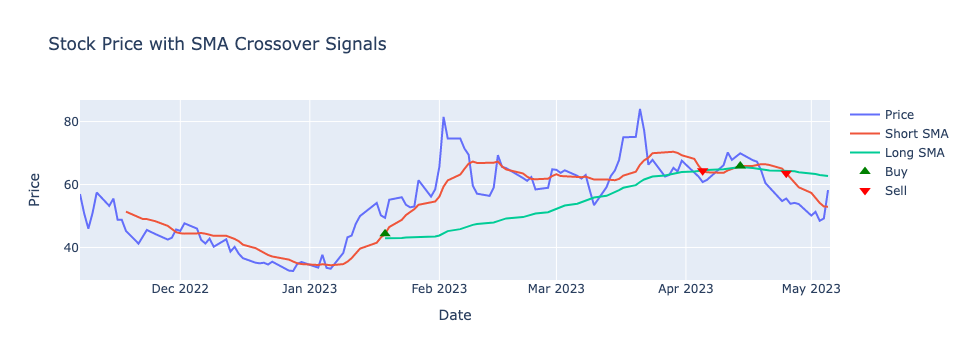

In [36]:
# Define the stock price trace
price = go.Scatter(
    x=data.index,
    y=data['Close'],
    name='Price',
)

# Define the short SMA trace
short_sma = go.Scatter(
    x=signals.index,
    y=signals['short_SMA'],
    name='Short SMA',
)

# Define the long SMA trace
long_sma = go.Scatter(
    x=signals.index,
    y=signals['long_SMA'],
    name='Long SMA',
)

# Define the buy signals trace
buy_signals = go.Scatter(
    x=signals.loc[signals.positions == 1.0].index,
    y=signals.short_SMA[signals.positions == 1.0],
    name='Buy',
    mode='markers',
    marker=dict(size=10, symbol='triangle-up', color='green'),
)

# Define the sell signals trace
sell_signals = go.Scatter(
    x=signals.loc[signals.positions == -1.0].index,
    y=signals.short_SMA[signals.positions == -1.0],
    name='Sell',
    mode='markers',
    marker=dict(size=10, symbol='triangle-down', color='red'),
)

# Define the layout
layout = go.Layout(
    title=dict(text='Stock Price with SMA Crossover Signals'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
)

# Create the figure
fig = go.Figure(data=[price, short_sma, long_sma, buy_signals, sell_signals], layout=layout)

# Display the figure
fig.show()

# Step 3: Measure Returns

In [37]:
# Calculate daily returns
signals['daily_returns'] = signals['price'].pct_change()

# Calculate daily returns when following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Filter out the periods when not holding the stock (strategy_returns == 0)
holding_returns = signals[signals['strategy_returns'] != 0]['strategy_returns']
cumulative_strategy_returns = (1 + holding_returns).cumprod()

print(cumulative_strategy_returns)


Date
2022-11-07         NaN
2023-01-20    1.116147
2023-01-23    1.132335
2023-01-24    1.083772
2023-01-25    1.067584
                ...   
2023-04-19    1.133637
2023-04-20    1.064324
2023-04-21    1.038640
2023-04-24    0.963170
2023-04-25    0.977243
Name: strategy_returns, Length: 61, dtype: float64


# Plot Cumulative Returns

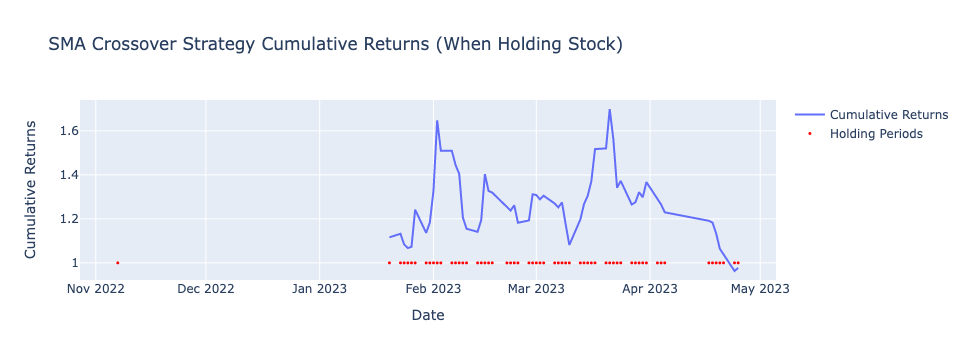

In [38]:

# Create a trace for the cumulative returns
cumulative_returns_trace = go.Scatter(
    x=cumulative_strategy_returns.index,
    y=cumulative_strategy_returns.values,
    mode='lines',
    name='Cumulative Returns'
)

# Create a trace for the holding periods
holding_periods_trace = go.Scatter(
    x=holding_returns.index,
    y=[1] * len(holding_returns),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Holding Periods'
)

# Create a layout for the chart
layout = go.Layout(
    title=dict(text='SMA Crossover Strategy Cumulative Returns (When Holding Stock)'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
)

# Create the figure
fig = go.Figure(data=[cumulative_returns_trace, holding_periods_trace], layout=layout)

# Display the figure
fig.show()

# Step 4: Compare Returns

In [39]:
# Calculate cumulative returns for buy-and-hold strategy
buy_and_hold_cumulative_returns = (1 + signals['daily_returns']).cumprod()
buy_and_hold_cumulative_returns

Date
2022-11-07         NaN
2022-11-08    0.892224
2022-11-09    0.807091
2022-11-10    0.893804
2022-11-11    1.008601
                ...   
2023-05-01    0.880112
2023-05-02    0.900825
2023-05-03    0.851150
2023-05-04    0.863963
2023-05-05    1.022292
Name: daily_returns, Length: 124, dtype: float64

# Plot Comparison

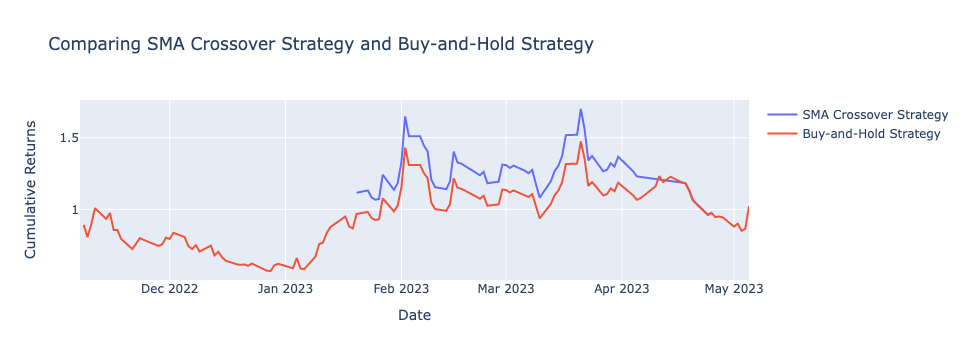

In [40]:

# Define the SMA Crossover strategy trace
sma_crossover_strategy = go.Scatter(
    x=holding_returns.index,
    y=cumulative_strategy_returns,
    mode='lines',
    name='SMA Crossover Strategy'
)

# Define the buy-and-hold strategy trace
buy_and_hold_strategy = go.Scatter(
    x=buy_and_hold_cumulative_returns.index,
    y=buy_and_hold_cumulative_returns,
    mode='lines',
    name='Buy-and-Hold Strategy'
)

# Define the layout
layout = go.Layout(
    title=dict(text='Comparing SMA Crossover Strategy and Buy-and-Hold Strategy'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
)

# Create the figure
fig = go.Figure(data=[sma_crossover_strategy, buy_and_hold_strategy], layout=layout)

# Display the figure
fig.show()

# Step 5: Compare Risk

###  Crossover Strategy Volatility

In [41]:
# Calculate the annualized volatility
annualized_volatility_SMA = holding_returns.std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", holding_returns.std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility_SMA)

Standard Deviation: 0.07345442585250897
Annualized Volatility: 1.1660528610166343


### Buy and Hold Volatility

In [42]:
# Calculate the annualized volatility
annualized_volatility = signals['daily_returns'].std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", signals['daily_returns'].std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility)

Standard Deviation: 0.07053626774000779
Annualized Volatility: 1.1197285371043717


### Sharpe Ratio

In [43]:
# Calculate the Sharpe Ratio

# Calculate daily returns when holding the stock following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Calculate the average daily returns
average_daily_returns = signals['daily_returns'].mean()
average_strategy_returns = signals['strategy_returns'].mean()

# Calculate the standard deviation of daily returns (volatility)
volatility_daily_returns = signals['daily_returns'].std()
volatility_strategy_returns = signals['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sharpe ratios
sharpe_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / volatility_daily_returns
sharpe_ratio_strategy = (average_strategy_returns - risk_free_rate) / volatility_strategy_returns

# Print the Sharpe ratios
print("Sharpe Ratio (Buy and Hold):", sharpe_ratio_buy_and_hold)
print("Sharpe Ratio (SMA Crossover Strategy):", sharpe_ratio_strategy)


Sharpe Ratio (Buy and Hold): 0.03550269700921212
Sharpe Ratio (SMA Crossover Strategy): 0.019233087002160004


### Sortino Ratio

In [44]:
# Calculate the Sortino Ratio

# Calculate the downside deviations (considering only negative returns)
downside_deviation_daily_returns = signals[signals['daily_returns'] < 0]['daily_returns'].std()
downside_deviation_strategy_returns = signals[signals['strategy_returns'] < 0]['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sortino ratios
sortino_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / downside_deviation_daily_returns
sortino_ratio_strategy = (average_strategy_returns - risk_free_rate) / downside_deviation_strategy_returns

# Print the Sortino ratios
print("Sortino Ratio (Buy and Hold):", sortino_ratio_buy_and_hold)
print("Sortino Ratio (SMA Crossover Strategy):", sortino_ratio_strategy)


Sortino Ratio (Buy and Hold): 0.0712366959195482
Sortino Ratio (SMA Crossover Strategy): 0.02737862765890916


### Maximum Drawdown

In [30]:
# Drop rows with missing or invalid values
signals.dropna(inplace=True)

# Calculate the running maximum cumulative returns
signals['running_max_bh'] = signals['buy_and_hold_cumulative_returns'].cummax()
signals['running_max_strategy'] = signals['strategy_cumulative_returns'].cummax()

# Check for any negative or zero values in the running maximum cumulative returns
print("Negative or zero values in 'running_max_bh':\n", signals[signals['running_max_bh'] <= 0])
print("Negative or zero values in 'running_max_strategy':\n", signals[signals['running_max_strategy'] <= 0])

# Calculate the drawdown for each time step
signals['drawdown_bh'] = signals['buy_and_hold_cumulative_returns'] / signals['running_max_bh'] - 1
signals['drawdown_strategy'] = signals['strategy_cumulative_returns'] / signals['running_max_strategy'] - 1

# Find the maximum drawdown for each strategy
max_drawdown_buy_and_hold = signals['drawdown_bh'].min()
max_drawdown_strategy = signals['drawdown_strategy'].min()

# Print the maximum drawdowns
print("Maximum Drawdown (Buy and Hold):", max_drawdown_buy_and_hold)
print("Maximum Drawdown (SMA Crossover Strategy):", max_drawdown_strategy)


KeyError: 'buy_and_hold_cumulative_returns'

# Step 5: Example starting with $10,000